In [1]:
import mmml
import matplotlib.pyplot as plt
import patchworklib as pw
import os
from pathlib import Path
import numpy as np
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.95"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import jax
devices = jax.local_devices()
print(devices)
print(jax.default_backend())
print(jax.devices())

[CudaDevice(id=0)]
gpu
[CudaDevice(id=0)]


<Figure size 100x100 with 0 Axes>

In [2]:
from mmml import dcmnet

In [3]:
import jax

from mmml.dcmnet.dcmnet.data import prepare_datasets
from mmml.dcmnet.dcmnet.modules import MessagePassingModel
from mmml.dcmnet.dcmnet.training import train_model, train_model_dipo

key = jax.random.PRNGKey(0)


In [4]:
NDCM = 4
model = MessagePassingModel(
    features=32, max_degree=2, num_iterations=2,
    num_basis_functions=32, cutoff=4.0, n_dcm=NDCM,
    include_pseudotensors=False,
)

## Data

In [5]:
# current_path = Path.cwd()
# print(current_path)
# data_path = Path("/mnt/d/data")
# data_files = list(data_path.glob("*npz"))
# for i in range(len(data_files)):
#     print(i, data_files[i])

In [6]:
index = 30
data_path_resolved = Path('/home/ericb/testmmml/test.npz') #data_files[index].resolve()
data_loaded = np.load(data_path_resolved, 
allow_pickle=True)
data_path_resolved

PosixPath('/home/ericb/testmmml/test.npz')

In [7]:
# factorize a number
def factorize(n):
    factors = []
    for i in range(1, n + 1):
        if n % i == 0:
            factors.append(i)
    return factors

factorize(data_loaded["esp"].shape[1])

[1, 2, 5, 10, 4451, 8902, 22255, 44510]

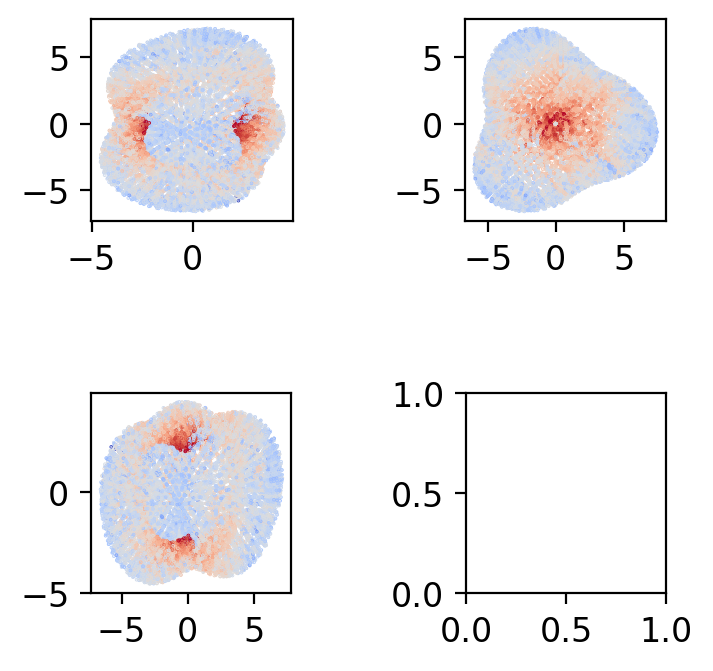

In [8]:
MAT = data_loaded["esp"]
from patchworklib import Brick

vrang = 4
ax1 = Brick()
ax1.scatter(data_loaded["esp_grid"][0][:,1], data_loaded["esp_grid"][0][:,2], s=0.1, c=MAT[0], cmap="coolwarm", vmin=-vrang, vmax=vrang)

ax2 = Brick()
ax2.scatter(data_loaded["esp_grid"][0][:,0], data_loaded["esp_grid"][0][:,2], s=0.1, c=MAT[0], cmap="coolwarm", vmin=-vrang, vmax=vrang)

ax3 = Brick()
s = ax3.scatter(data_loaded["esp_grid"][0][:,2], data_loaded["esp_grid"][0][:,1], s=0.1, c=MAT[0], cmap="coolwarm", vmin=-vrang, vmax=vrang)

ax4 = Brick()
(ax1 | ax2) / (ax3 | ax4)


R
(1983, 18, 3)
D
(1983, 3)


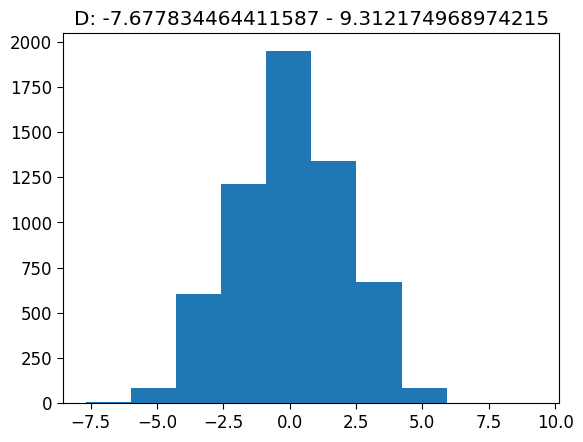

Q
(1983, 3, 3)
Z
(1983, 18)


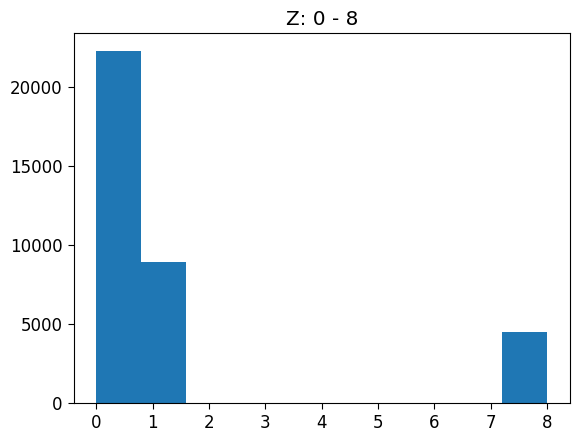

esp
(1983, 44510)


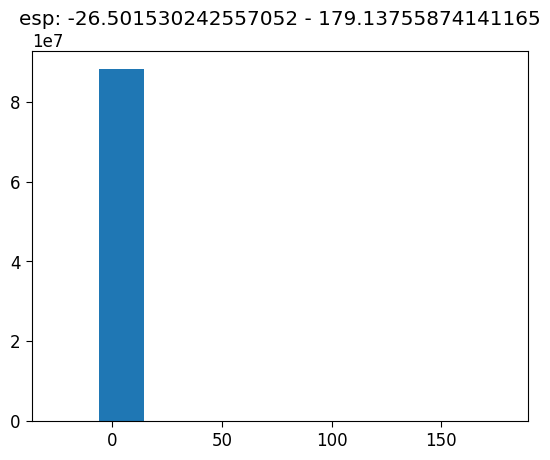

esp_grid
(1983, 44510, 3)
F
(1983, 18, 3)


In [9]:
for k in data_loaded.keys():
    print(k)
    shape = data_loaded[k].shape
    print(shape
    )
    if len(shape) < 3:
        try:
            d = data_loaded[k]
            d = d.flatten()
            plt.hist(d)
            title = f"{k}: {d.min()} - {d.max()}"
            plt.title(title)
            plt.show()
        except:
            pass

In [10]:
prepare_datasets?

Signature:
prepare_datasets(
    key,
    num_train,
    num_valid,
    filename,
    clean=False,
    esp_mask=False,
    clip_esp=False,
    natoms=60,
)
Docstring:
Prepare datasets for training and validation.

Wrapper function that calls prepare_multiple_datasets and then
creates train/validation splits and dictionaries.

Parameters
----------
key : jax.random.PRNGKey
    Random key for dataset shuffling
num_train : int
    Number of training samples
num_valid : int
    Number of validation samples
filename : str or list
    Filename(s) to load datasets from
clean : bool, optional
    Whether to filter failed calculations, by default False
esp_mask : bool, optional
    Whether to create ESP masks, by default False
clip_esp : bool, optional
    Whether to clip ESP to first 1000 points, by default False
natoms : int, optional
    Maximum number of atoms per system, by default 60

Returns
-------
tuple
    A tuple containing train_data and valid_data dictionaries
File:      ~/mmml/mmm

In [11]:
train_data, valid_data = prepare_datasets(
    key, num_train=1200, num_valid=100,
    filename=[data_path_resolved],
    clean= False, esp_mask=False,
    # clip_esp=True,
    natoms=18,
)




shape (1983, 18, 3)
D (1983, 3)
Q 3 (1983, 3, 3) 1983
Q (1983, 3, 3)
R (1983, 18, 3)
(1983, 18, 3)
['R', 'Z', 'F', 'esp', 'D', 'esp_grid', 'Q']
1983
0 R 1983 (1983, 18, 3)
1 Z 1983 (1983, 18)
2 F 1983 (1983, 18, 3)
3 esp 1983 (1983, 44510)
4 D 5949 (5949, 1)
5 esp_grid 1983 (1983, 44510, 3)
6 Q 1983 (1983, 3, 3)


In [12]:
train_data["vdw_surface"] = train_data["esp_grid"]
valid_data["vdw_surface"] = valid_data["esp_grid"]
train_data["mono"] = train_data["Z"]*0.0
valid_data["mono"] = valid_data["Z"]*0.0
train_data["n_grid"] = train_data["D"]*0.0 + 44510
valid_data["n_grid"] = valid_data["D"]*0.0 + 44510
train_data["N"] = np.count_nonzero(train_data["Z"] , axis=-1)
valid_data["N"] = np.count_nonzero(valid_data["Z"] , axis=-1)


In [13]:

model.n_dcm

4

In [14]:
esp_data = train_data["esp"]
esp_data.shape

(1200, 44510)

## Training (1)

In [15]:
train_model?

Signature:     
train_model(
    key,
    model,
    train_data,
    valid_data,
    num_epochs,
    learning_rate,
    batch_size,
    writer,
    ndcm,
    esp_w=1.0,
    restart_params=None,
    *,
    loss_step_fn: Callable = <PjitFunction of <function train_step at 0x7f52bcb06840>>,
    eval_step_fn: Callable = <PjitFunction of <function eval_step at 0x7f52bc8dd9e0>>,
    optimizer_fn: Callable = <function <lambda> at 0x7f52bc8de520>,
    use_ema: bool = True,
    ema_decay: float = 0.999,
    use_grad_clip: bool = False,
    grad_clip_norm: float = 2.0,
    log_extra_metrics: Optional[Callable] = <function _log_extra_metrics_none at 0x7f52bc8de3e0>,
    save_best_params_with_ema: bool = True,
    extra_valid_args: dict = None,
    extra_train_args: dict = None,
)
Call signature: train_model(*args, **kwargs)
Type:           partial
String form:    functools.partial(<function train_model_general at 0x7f52bc8de340>, loss_step_fn=<PjitFunction of <...> tra_metrics=<function _log_extr

In [16]:
new_params = None

params, valid_loss = train_model(
    key=key, model=model,
    writer=None,
    train_data=train_data, valid_data=valid_data,
    num_epochs=30, learning_rate=1e-3, batch_size=1,
    ndcm=model.n_dcm, esp_w=10000.0,
)



Preparing batches
..................


TypeError: Gradient only defined for scalar-output functions. Output had shape: (1,).

In [ ]:
params['params'].keys()



dict_keys(['Dense_0', 'Dense_1', 'Dense_2', 'Dense_3', 'Dense_4', 'Embed_0', 'MessagePass_0', 'MessagePass_1', 'TensorDense_0', 'element_bias'])

In [ ]:
from mmml.dcmnet.dcmnet.analysis import dcmnet_analysis, prepare_batch

?dcmnet_analysis
?prepare_batch

<Figure size 640x480 with 0 Axes>

Signature: prepare_batch(path: pathlib.Path, index=0, data=None)
Docstring:
Prepare a single batch from data for analysis.

Parameters
----------
path : Path
    Path to the data file
index : int, optional
    Index of the data to prepare
data : dict, optional
    Data dictionary to use instead of loading from file
    
Returns
-------
dict
    Batch dictionary ready for model input
File:      ~/mmml/mmml/dcmnet/dcmnet/analysis.py
Type:      function

In [ ]:
index

30

In [ ]:
batch = prepare_batch(data_files[28], index=0)
batch['com'] = np.mean(batch['R'].T, axis=-1) # center of mass
batch["Dxyz"] = batch["R"] - batch["com"]
output = dcmnet_analysis(new_params, model, batch)
print(output["rmse_model_masked"]), print(output["rmse_model"])
output.keys()

dict_keys(['R', 'Z', 'N', 'D', 'com', 'Dxyz', 'mono', 'esp', 'id', 'n_grid', 'vdw_surface'])
(1, 60)
1.5789763
1.880272


dict_keys(['mono', 'dipo', 'D_xyz_pred', 'D_mae', 'esp_pred', 'mask', 'closest_atom_type', 'closest_atom', 'rmse_model', 'rmse_model_masked'])

In [ ]:
batch.keys()

dict_keys(['R', 'Z', 'N', 'D', 'com', 'Dxyz', 'mono', 'esp', 'n_grid', 'vdw_surface', 'dst_idx', 'src_idx', 'batch_segments'])

In [ ]:
import ase
from ase.visualize import view
atoms = ase.Atoms(batch["Z"][:int(batch["N"])], 
batch["R"][:int(batch["N"])])
view(atoms, viewer="x3d")


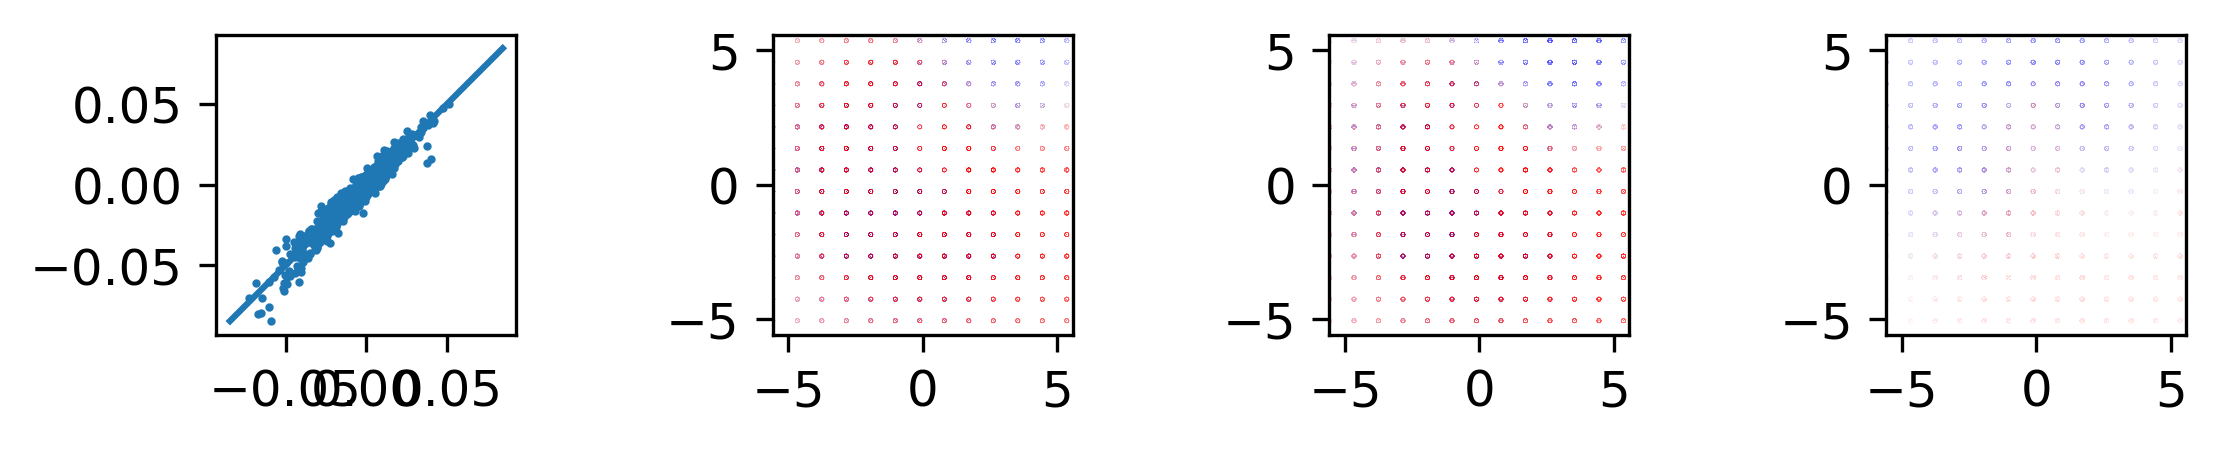

In [ ]:
import patchworklib as pw
VMAX = 0.01
xy_ax = pw.Brick()
xy_ax.scatter(batch["esp"], output['esp_pred'], s=1)
max_val = np.sqrt(max(np.max(batch["esp"]**2), np.max(output['esp_pred']**2)))
xy_ax.plot(np.linspace(-max_val, max_val, 100), np.linspace(-max_val, max_val, 100))
xy_ax.set_aspect('equal')

ax_true = pw.Brick()
Npoints = 4150
vdw_surface_min = np.min(batch["vdw_surface"][0], axis=-1)
vdw_surface_max = np.max(batch["vdw_surface"][0], axis=-1)

ax_true.scatter(
    batch["vdw_surface"][0][:Npoints,0], 
batch["vdw_surface"][0][:Npoints,1], 
c=batch["esp"][0][:Npoints],
s=0.01,
    vmin=-VMAX, vmax=VMAX
)
max_val = np.sqrt(max(np.max(batch["esp"]**2), np.max(output['esp_pred']**2)))
# ax.plot(np.linspace(-max_val, max_val, 100), np.linspace(-max_val, max_val, 100))
ax_true.set_aspect('equal')

ax_pred = pw.Brick()

ax_pred.scatter(
    batch["vdw_surface"][0][:Npoints,0], 
batch["vdw_surface"][0][:Npoints,1], 
c=output['esp_pred'][:Npoints],
s=0.01,
    vmin=-VMAX, vmax=VMAX
)
max_val = np.sqrt(max(np.max(batch["esp"]**2), np.max(output['esp_pred']**2)))
# ax.plot(np.linspace(-max_val, max_val, 100), np.linspace(-max_val, max_val, 100))
ax_pred.set_aspect('equal')


ax_diff = pw.Brick()
ax_diff.scatter(
    batch["vdw_surface"][0][:Npoints,0], 
batch["vdw_surface"][0][:Npoints,1], 
c=batch["esp"][0][:Npoints] - output['esp_pred'][:Npoints],
s=0.01,
    vmin=-VMAX, vmax=VMAX
)
ax_diff.set_aspect('equal')

for _ in [ax_pred, ax_true, ax_diff]:
    _.set_xlim(vdw_surface_min[0], -vdw_surface_min[0])
    _.set_ylim(vdw_surface_min[1], -vdw_surface_min[0])


xy_ax | ax_pred | ax_true | ax_diff



In [ ]:
output["mono"][0][:int(batch["N"])].sum(axis=-1)


Array([-0.60177374, -0.5984309 , -0.61041033,  0.74271226,  0.703992  ,
        0.69741076, -0.59207046, -0.5492721 , -0.56834424, -0.63734305,
       -0.2036105 , -0.218788  , -0.2055957 ,  0.35238618,  0.35977483,
        0.36544904,  0.20170677,  0.18494189,  0.16920483,  0.12905563,
        0.12795275,  0.1336764 ,  0.16546541,  0.13727152,  0.17806241,
        0.13657522], dtype=float32)

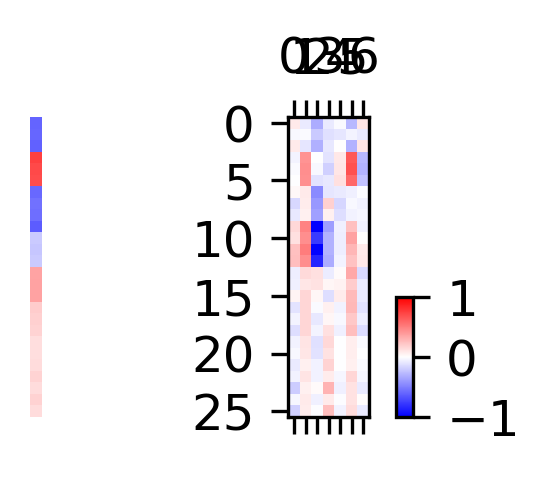

In [ ]:
charge_ax = pw.Brick()
charge_ax.matshow(output["mono"][0][:int(batch["N"])],vmin=-1,vmax=1)
scharge_ax = pw.Brick()
scharge_ax.matshow(output["mono"][0][:int(batch["N"])].sum(axis=-1)[:, None],vmin=-1,vmax=1)
# scharge_ax.add_colorbar(vmin=-1,vmax=1)
scharge_ax.axis("off")
f = (scharge_ax | charge_ax)
f.add_colorbar(vmin=-1,vmax=1)

In [ ]:
R = output["dipo"][:int(batch["N"])*NDCM]
Z = np.array([1 if _ > 0 else 1 for _ in output["mono"][0][:int(batch["N"])].flatten()])
R.shape, Z.shape
dcm_atoms = ase.Atoms(Z, R)
view(dcm_atoms,  viewer="x3d")

In [ ]:
new_params, valid_loss = train_model(
    key=key, model=model,
    writer=None,
    train_data=train_data, valid_data=valid_data,
    num_epochs=100, learning_rate=5e-4, batch_size=1,
    ndcm=model.n_dcm, esp_w=1000.0,
    restart_params=params if new_params is None else new_params,
)

Preparing batches
..................



KeyboardInterrupt

